In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV




In [3]:
df = pd.read_csv('../data/creditcard.csv')

In [9]:
# Properties (X) and target variable (y)
X = df.drop('Class' , axis=1) # axis=1 means deleting column. axis=0 means deleting line.
y = df['Class']

Class
1    492
0    492
Name: count, dtype: int64


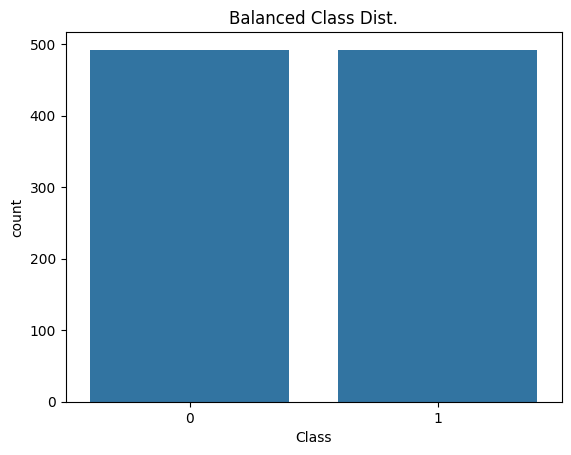

In [12]:
# Separate the majority and minority classes
df_majority = df[df['Class'] == 0]  # Real transactions
df_minority = df[df['Class'] == 1]  # Fraudulent transactions

# Under-sample the majority class, keep the minority class as what is it
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# Creating the new balanced dataset
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffeling the dataset(beacuse classses might be ordered)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Checking the new class dist
print(df_balanced['Class'].value_counts())

# Visualize the new class distribution
sns.countplot(x='Class', data=df_balanced)
plt.title('Balanced Class Dist.')
plt.show()


In [13]:
X = df_balanced.drop('Class', axis=1)
y = df_balanced['Class']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=35
)


In [15]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
model = RandomForestClassifier(random_state=42)


model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

In [17]:
y_pred = model.predict(X_test_scaled)

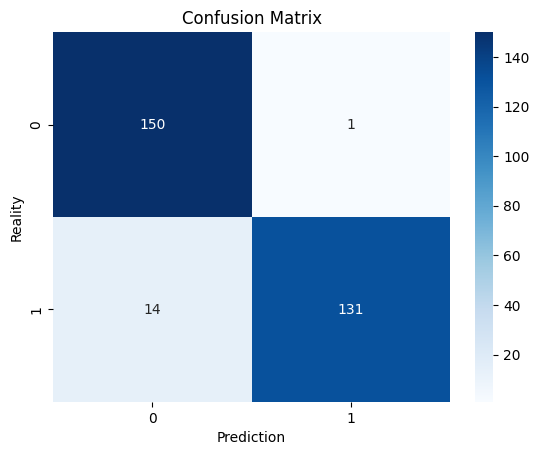

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       151
           1       0.99      0.90      0.95       145

    accuracy                           0.95       296
   macro avg       0.95      0.95      0.95       296
weighted avg       0.95      0.95      0.95       296



In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Actual')
plt.ylabel('Reality')
plt.show()

print(classification_report(y_test, y_pred))


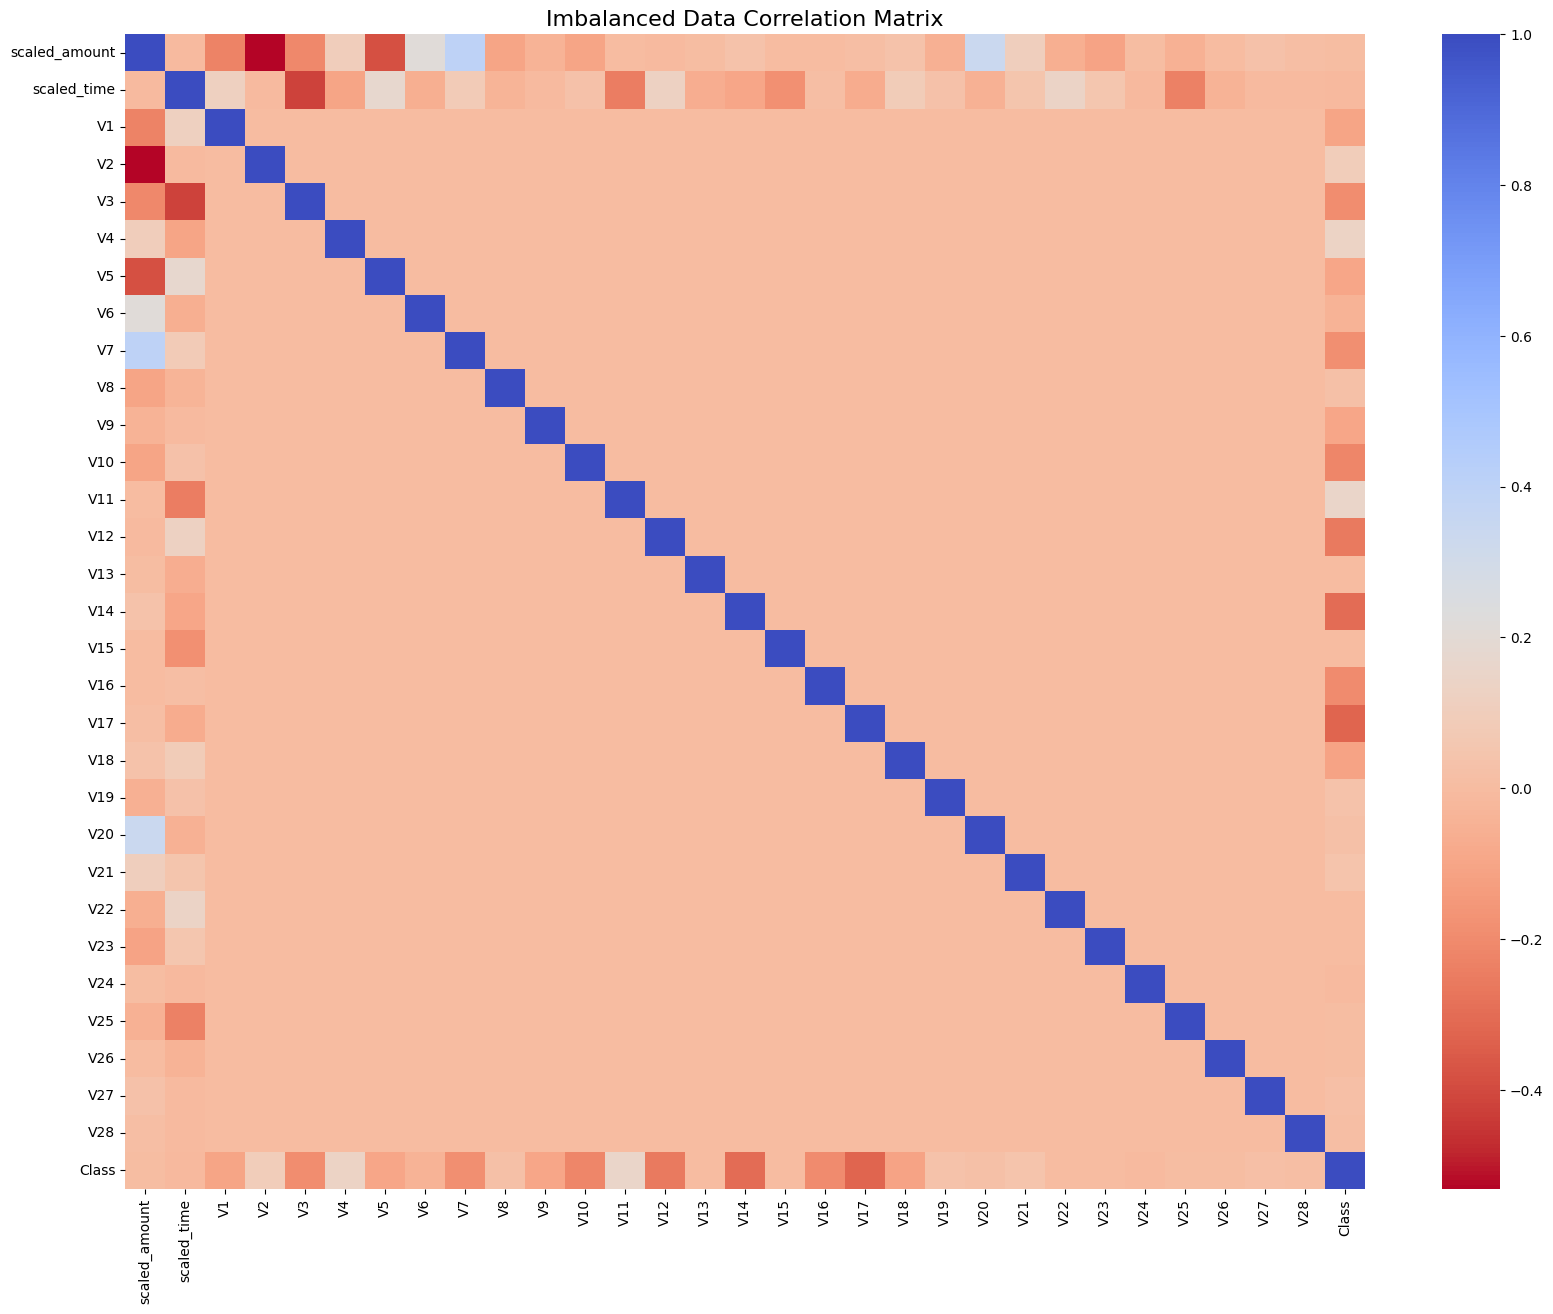

In [ ]:
corr = df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, cmap='coolwarm_r', annot=False)  # annot=True yaparsan kutuların içine değerleri de yazdırır
plt.title('Balanced Data Correlation Matrix', fontsize=16)
plt.show()

In [28]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [27]:

for name, model in classifiers.items():

    model.fit(X_train_scaled, y_train)
    
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    print(f"Classifier: {name} has an average training accuracy of {round(cv_scores.mean() * 100, 2)}%")


Classifier: Logistic Regression has an average training accuracy of 93.89%
Classifier: K-Nearest Neighbors has an average training accuracy of 91.72%
Classifier: Support Vector Machine has an average training accuracy of 92.59%
Classifier: Decision Tree has an average training accuracy of 90.7%
Classifier: RandomForestClassifier has an average training accuracy of 93.31%


In [29]:
log_reg_params = {
    "penalty": ['l1', 'l2'],
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "solver": ['liblinear']  # l1 cezası için solver belirtmek gerek
}

knears_params = {
    "n_neighbors": list(range(2, 5)),
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
}

svc_params = {
    "C": [0.5, 0.7, 0.9, 1],
    "kernel": ['rbf', 'poly', 'sigmoid', 'linear']
}

tree_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": list(range(2, 4)),
    "min_samples_leaf": list(range(5, 7))
}

rf_params = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# GridSearchCV
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, cv=5, n_jobs=-1)
grid_log_reg.fit(X_train_scaled, y_train)
log_reg_best = grid_log_reg.best_estimator_

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, cv=5, n_jobs=-1)
grid_knears.fit(X_train_scaled, y_train)
knears_best = grid_knears.best_estimator_

grid_svc = GridSearchCV(SVC(), svc_params, cv=5, n_jobs=-1)
grid_svc.fit(X_train_scaled, y_train)
svc_best = grid_svc.best_estimator_

grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, n_jobs=-1)
grid_tree.fit(X_train_scaled, y_train)
tree_best = grid_tree.best_estimator_

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)
rf_best = grid_rf.best_estimator_

best_classifiers = {
    "Logistic Regression": log_reg_best,
    "K-Nearest Neighbors": knears_best,
    "Support Vector Classifier": svc_best,
    "Decision Tree Classifier": tree_best,
    "Random Forest Classifier": rf_best
}

print("\nCross Validation Scores after Hyperparameter Tuning:\n")
for name, model in best_classifiers.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"{name}: {round(scores.mean() * 100, 2)}% accuracy")


Cross Validation Scores after Hyperparameter Tuning:

Logistic Regression: 93.89% accuracy
K-Nearest Neighbors: 92.0% accuracy
Support Vector Classifier: 94.18% accuracy
Decision Tree Classifier: 91.28% accuracy
Random Forest Classifier: 93.31% accuracy
